In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [30]:
import os

In [31]:
base_dir = '..\AlexNet\data'
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
    validation_split=.1
)

batch_size = 128

# train dataset 불러오기
trainGen = imageGenerator.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    subset='training',
    class_mode='categorical'
)

# val dataset 불러오기
validationGen = imageGenerator.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    subset='validation',
    class_mode='categorical'
)

Found 2426 images belonging to 7 classes.
Found 33 images belonging to 7 classes.


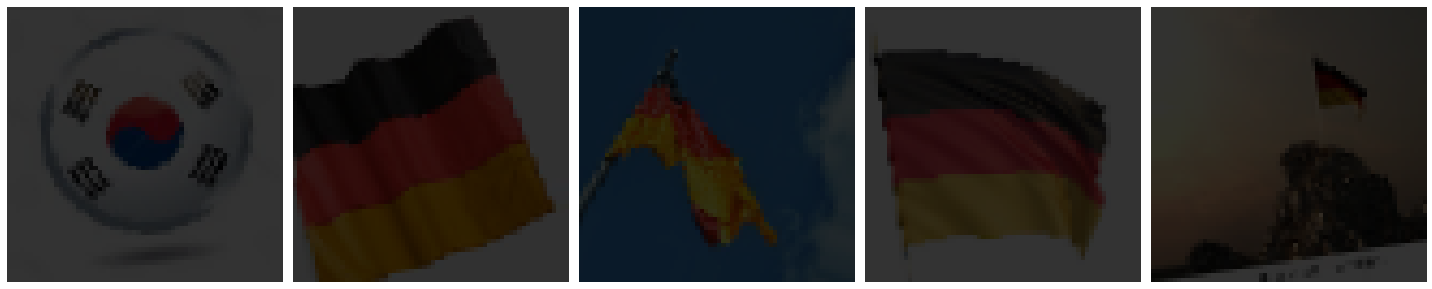

In [33]:
#옮겨 담기
sample_training_images, _ = next(trainGen)

# 이미지를 보여주는 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

In [48]:
class LocalResponseNormalization(Layer):

    def __init__(self, n=5, alpha=1e-4, beta=0.75, k=2, **kwargs):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LocalResponseNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LocalResponseNormalization, self).build(input_shape)

    def call(self, x):
        _, r, c, f = self.shape 
        squared = K.square(x)
        pooled = K.pool2d(squared, (self.n, self.n), strides=(1,1), padding="same", pool_mode='avg')
        summed = K.sum(pooled, axis=3, keepdims=True)
        averaged = self.alpha * K.repeat_elements(summed, f, axis=3)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom 
    
    def compute_output_shape(self, input_shape):
        return input_shape 

In [74]:
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Flatten, Dropout, MaxPooling2D

# model = keras.Sequential([
#     Flatten(input_shape=(64, 64)),
#     Dense(128, activation='relu'),
#     Dense(7, activation='softmax')
# ])

model = keras.Sequential([ 
    InputLayer(input_shape=(64,64,3)),
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    LocalResponseNormalization(input_shape=model.output_shape[1:]),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    LocalResponseNormalization(input_shape=model.output_shape[1:]),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    LocalResponseNormalization(input_shape=model.output_shape[1:]),
    
    Flatten(),
    Dense(4096, activation='relu'),
    
    Dropout(0.5),
    Dense(128, activation='relu'),
    
    Dropout(0.5),
    Dense(7, activation='softmax'),
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
local_response_normalization (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
local_response_normalization (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 16, 16, 64)      

In [75]:
trainGen.labels[0]

0

In [76]:
epochs = 5

history = model.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/5
486/485 [==============================] - 180s 371ms/step - loss: 0.9097 - accuracy: 0.6688 - val_loss: 0.8141 - val_accuracy: 0.7263
Epoch 2/5
486/485 [==============================] - 167s 343ms/step - loss: 0.3501 - accuracy: 0.8920 - val_loss: 0.6219 - val_accuracy: 0.7744
Epoch 3/5
486/485 [==============================] - 173s 355ms/step - loss: 0.2374 - accuracy: 0.9269 - val_loss: 0.6502 - val_accuracy: 0.8032
Epoch 4/5
486/485 [==============================] - 180s 370ms/step - loss: 0.1911 - accuracy: 0.9427 - val_loss: 0.4568 - val_accuracy: 0.8375
Epoch 5/5
486/485 [==============================] - 169s 348ms/step - loss: 0.1508 - accuracy: 0.9569 - val_loss: 0.6076 - val_accuracy: 0.8048


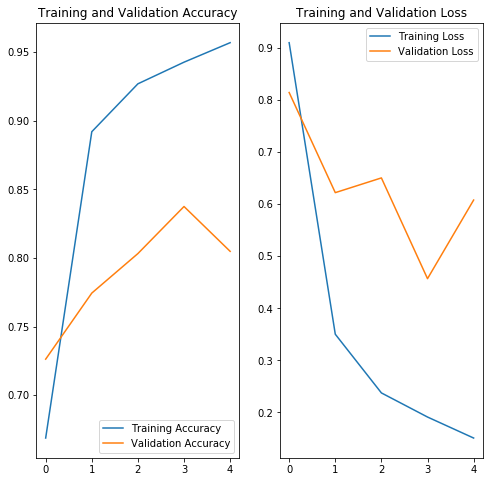

In [77]:
epochs_range = range(epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_dir = os.path.join(base_dir,'test')

testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    test_dir,
    target_size=(64, 64),
)

# loss and accuracy
model.evaluate(testGen)